In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from WassersteinTSNE import GaussianDistribution, plotGaussian, RotationMatrix, MirrorMatrix
from sklearn.decomposition import PCA

import sys
sys.path.insert(0, '../src')
import utils.visualization as vis

## Load Data

In [2]:
candidates = pd.read_csv('../data/candidates.csv', index_col=0)
candidate_reactions = pd.read_csv('../data/candidates_reactions.csv', index_col=0)
voters_reactions = pd.read_csv('../data/voters_reactions.csv', index_col=0)
true_means = pd.read_csv('../data/party_means.csv', index_col=0)
true_stds = pd.read_csv('../data/party_stds.csv', index_col=0)
true_means.head()

,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
32214,0.522222,0.465054,0.979839,0.781046,0.185268,0.503401,0.022222,0.558962,0.278409
32215,0.400000,0.857527,0.108871,0.645425,0.917411,0.675170,0.987037,0.110849,0.615057
32216,0.716667,0.943548,0.673387,0.522876,0.859375,0.933673,0.681481,0.497642,0.784091
32217,0.316667,0.588710,0.899194,0.754902,0.069196,0.693878,0.038889,0.669811,0.264205
32218,0.277778,0.801075,0.197581,0.848039,0.968750,0.744898,0.979630,0.073113,0.569602


In [3]:
gpt_data = []
temperatures = {10:1.0, 12:1.25, 15:1.5, 17:1.75, 20:2.0}
for temperature in temperatures.keys():
    tmp = []
    for party in true_means.columns:
        data = pd.read_csv(f"../results/gpt/2023/GPT4_T{temperature}_{party}.csv", index_col=0).T/100
        data.index = [f'{party}_{temperatures[temperature]}' for i in data.index]
        tmp.append(data)
    gpt_data.append(pd.concat(tmp, axis=0))
gpt_data = pd.concat(gpt_data, axis=0)
gpt_data.index = pd.MultiIndex.from_tuples([tuple(idx.split('_')) for idx in gpt_data.index], names=['party', 'temperature'])
# Apply condition to replace values with NaN
gpt_data = gpt_data.applymap(lambda x: x if 0 <= x <= 1 else np.nan)
gpt_data.to_csv('../results/gpt/2023/gpt4_results.csv')
gpt_data

ID_question         32214  32215  32216  32217  32218  32219  32220  32221   
party  temperature                                                           
EDU    1.0           0.25   0.60   0.00   0.00   0.30   0.25   0.00   0.00  \
       1.0           0.00   0.50   0.00   0.00   0.30   0.30   0.00   0.00   
       1.0           0.00   0.50   0.50   0.00   0.00   0.30   0.35   0.00   
       1.0           0.00   0.70   0.00   0.00   0.35   0.30   0.00   0.00   
       1.0           0.50   0.50   0.00   0.00   0.40   0.30   0.00   0.00   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
Übrige 2.0           0.52   0.34   0.99   0.00   0.75   0.20   0.57   0.90   
       2.0           0.60   0.50   0.53   0.50   0.80   0.44   0.50   0.10   
       2.0           0.40   0.60   1.00   0.35   0.60   0.60   0.69   0.85   
       2.0           0.50   0.56   0.50   0.20   0.81   0.50   0.60   0.50   
       2.0           0.67   0.40   0.60   0.00   0.00   0.50   0.46   0.50   

ID_question         32222  32223  ...  32279  32280  32281  32282  32283   
party  temperature                ...                                      
EDU    1.0           0.40   1.00  ...   0.60   0.30   0.50   0.50   0.50  \
       1.0           0.00   1.00  ...   0.50   0.20   0.50   0.50   0.50   
       1.0           0.50   1.00  ...   0.85   0.20   0.30   0.50   0.50   
       1.0           0.30   1.00  ...   0.60   0.35   0.50   0.40   0.50   
       1.0           0.20   0.80  ...   0.60   0.30   0.30   0.40   0.50   
...                   ...    ...  ...    ...    ...    ...    ...    ...   
Übrige 2.0           0.20   0.85  ...   0.20   0.72   0.45   1.00   0.26   
       2.0           0.70   0.85  ...   0.30   0.70   0.65   0.80   0.50   
       2.0           0.50   0.70  ...   0.20   0.50   0.78   0.68   1.00   
       2.0           0.45   1.00  ...   0.30   0.74   0.75   0.70   0.58   
       2.0           0.50   1.00  ...   0.20   0.90   0.50   0.75   0.50   

ID_question         32284  32285  32286  32287  32288  
party  temperature                                     
EDU    1.0           0.50   0.50   0.80   0.70    0.3  
       1.0           0.30   0.85   0.70   0.70    0.3  
       1.0           0.50   0.50   0.80   0.75    0.3  
       1.0           0.50   0.60   1.00   0.50    0.3  
       1.0           0.70   0.70   0.80   0.50    0.3  
...                   ...    ...    ...    ...    ...  
Übrige 2.0           0.65   0.50   0.70   0.50    0.5  
       2.0           0.50   0.65   0.70   0.50    0.5  
       2.0           0.50   0.48   0.50   0.37    0.5  
       2.0           0.65   0.50   0.20   0.50    0.5  
       2.0           0.81   0.50   0.75   0.50    0.2  

[450 rows x 75 columns]

In [ ]:
# coldstart = gpt_data.loc[gpt_data.index.get_level_values(1) != '2.0']
coldstart = gpt_data.droplevel(1)
coldstart = coldstart.loc[coldstart.index != "Übrige"]
coldstart.to_csv('../data/gpt_data.csv')
coldstart


ID_question,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32279,32280,32281,32282,32283,32284,32285,32286,32287,32288
party,,,,,,,,,,,,,,,,,,,,,
EDU,0.25,0.60,0.00,0.00,0.30,0.25,0.00,0.00,0.40,1.00,...,0.60,0.30,0.50,0.50,0.50,0.50,0.50,0.8,0.70,0.3
EDU,0.00,0.50,0.00,0.00,0.30,0.30,0.00,0.00,0.00,1.00,...,0.50,0.20,0.50,0.50,0.50,0.30,0.85,0.7,0.70,0.3
EDU,0.00,0.50,0.50,0.00,0.00,0.30,0.35,0.00,0.50,1.00,...,0.85,0.20,0.30,0.50,0.50,0.50,0.50,0.8,0.75,0.3
EDU,0.00,0.70,0.00,0.00,0.35,0.30,0.00,0.00,0.30,1.00,...,0.60,0.35,0.50,0.40,0.50,0.50,0.60,1.0,0.50,0.3
EDU,0.50,0.50,0.00,0.00,0.40,0.30,0.00,0.00,0.20,0.80,...,0.60,0.30,0.30,0.40,0.50,0.70,0.70,0.8,0.50,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SVP,0.80,0.25,0.15,1.00,0.30,0.20,0.15,0.20,0.70,0.75,...,0.85,0.30,0.25,0.35,0.60,0.25,1.00,0.8,0.80,0.1
SVP,NaN,0.00,0.20,0.00,0.20,0.20,0.30,0.00,0.56,1.00,...,0.85,0.30,0.10,0.30,0.80,0.40,0.70,0.9,1.00,0.3
SVP,0.70,0.20,0.50,0.00,0.15,0.30,0.50,0.15,0.60,0.90,...,0.80,0.20,0.20,0.30,0.80,0.30,0.75,0.8,0.90,0.1


In [5]:
gpt_means = gpt_data.groupby(level=0).mean().T
gpt_stds = gpt_data.groupby(level=0).std().T
gpt_means.head()

party,EDU,EVP,FDP,GLP,Grüne,Mitte,SP,SVP,Übrige
ID_question,,,,,,,,,
32214,0.209400,0.274400,0.760208,0.698600,0.1390,0.5450,0.129000,0.76875,0.482400
32215,0.482800,0.803200,0.352000,0.672653,0.9040,0.7558,0.970000,0.24100,0.554000
32216,0.189796,0.440408,0.620000,0.504600,0.7246,0.4948,0.780204,0.23900,0.569796
32217,0.018000,0.162400,0.760400,0.676200,0.0560,0.5344,0.009000,0.26700,0.305000
32218,0.256531,0.883400,0.424000,0.865000,1.0000,0.7940,0.998000,0.21560,0.711000


### GPT Predictions in PCA

In [14]:
pca = PCA(n_components=2)
X = pca.fit_transform(candidate_reactions)
E = pd.DataFrame(X, index = candidates['list'], columns=['X','Y'])

X = pca.transform(gpt_means.T.fillna(.5))
P = pd.DataFrame(X, index = gpt_means.columns, columns=['X','Y'])

/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


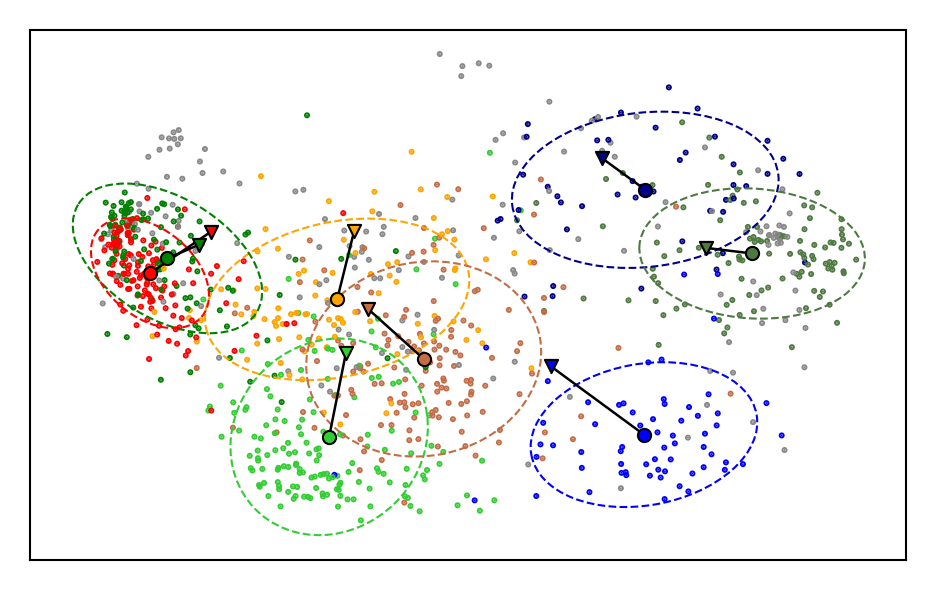

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(vis.columnwidth, 2*vis.columnwidth))
X,Y = E.values.T
c = E.index.to_series().map(vis.party_colors).values
ax.scatter(X,Y, c=c, s=.2, lw=1)
# ax.set_title('GPT 2023')
for name, data in E.groupby(level=0):
    if len(data) > 1 and name != "Übrige":
        G = GaussianDistribution().estimate(data)
        x_mean,y_mean = G.mean
        c = vis.party_colors.get(name, 'gray')
        ax.scatter(x_mean,y_mean, c=c, marker='o', s=10,  edgecolors='black', lw=.5, zorder=3)
        plotGaussian(G, size=0, STDS=[1.5], color=c, lw=.5, ax=ax)
        x, y = P.loc[name]
        ax.plot([x_mean, x], [y_mean,y], c='black', lw=.6)
        ax.scatter(x,y, c=c, s=10, edgecolors='black', marker='v', lw=.5 ,zorder=4, label=name)

# _ = ax.legend(ncol=4)
ax.set_aspect('equal')

# Creating custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Data Points',
           markerfacecolor=c, markersize=1, markeredgecolor='black', lw=0.5),
    Patch(facecolor='none', edgecolor=c, label='Gaussian Ellipse', linestyle='--', lw=0.5),
    Line2D([0], [0], marker='v', color='w', label='Mean Point',
           markerfacecolor=c, markersize=1, markeredgecolor='black', lw=0.5)
]

# Adding the legend to the plot
# ax.legend(handles=legend_elements, loc='best')
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

#### GPT Predictions in Heatmap

In [5]:
diff = (true_means - gpt_means).abs().mean()
diff

EDU       0.152470
EVP       0.157446
FDP       0.180770
GLP       0.135670
Grüne     0.087650
Mitte     0.177997
SP        0.116564
SVP       0.121153
Übrige    0.129569
dtype: float64

,diff,score,wass
EDU,0.152470,0.530233,0.246739
EVP,0.157446,0.568785,0.273474
FDP,0.180770,0.750516,0.290104
GLP,0.135670,0.554522,0.237706
Grüne,0.087650,0.405547,0.217957
Mitte,0.177997,0.610231,0.313518
SP,0.116564,0.798495,0.202708
SVP,0.121153,inf,0.252460
Übrige,0.129569,0.335024,0.258083


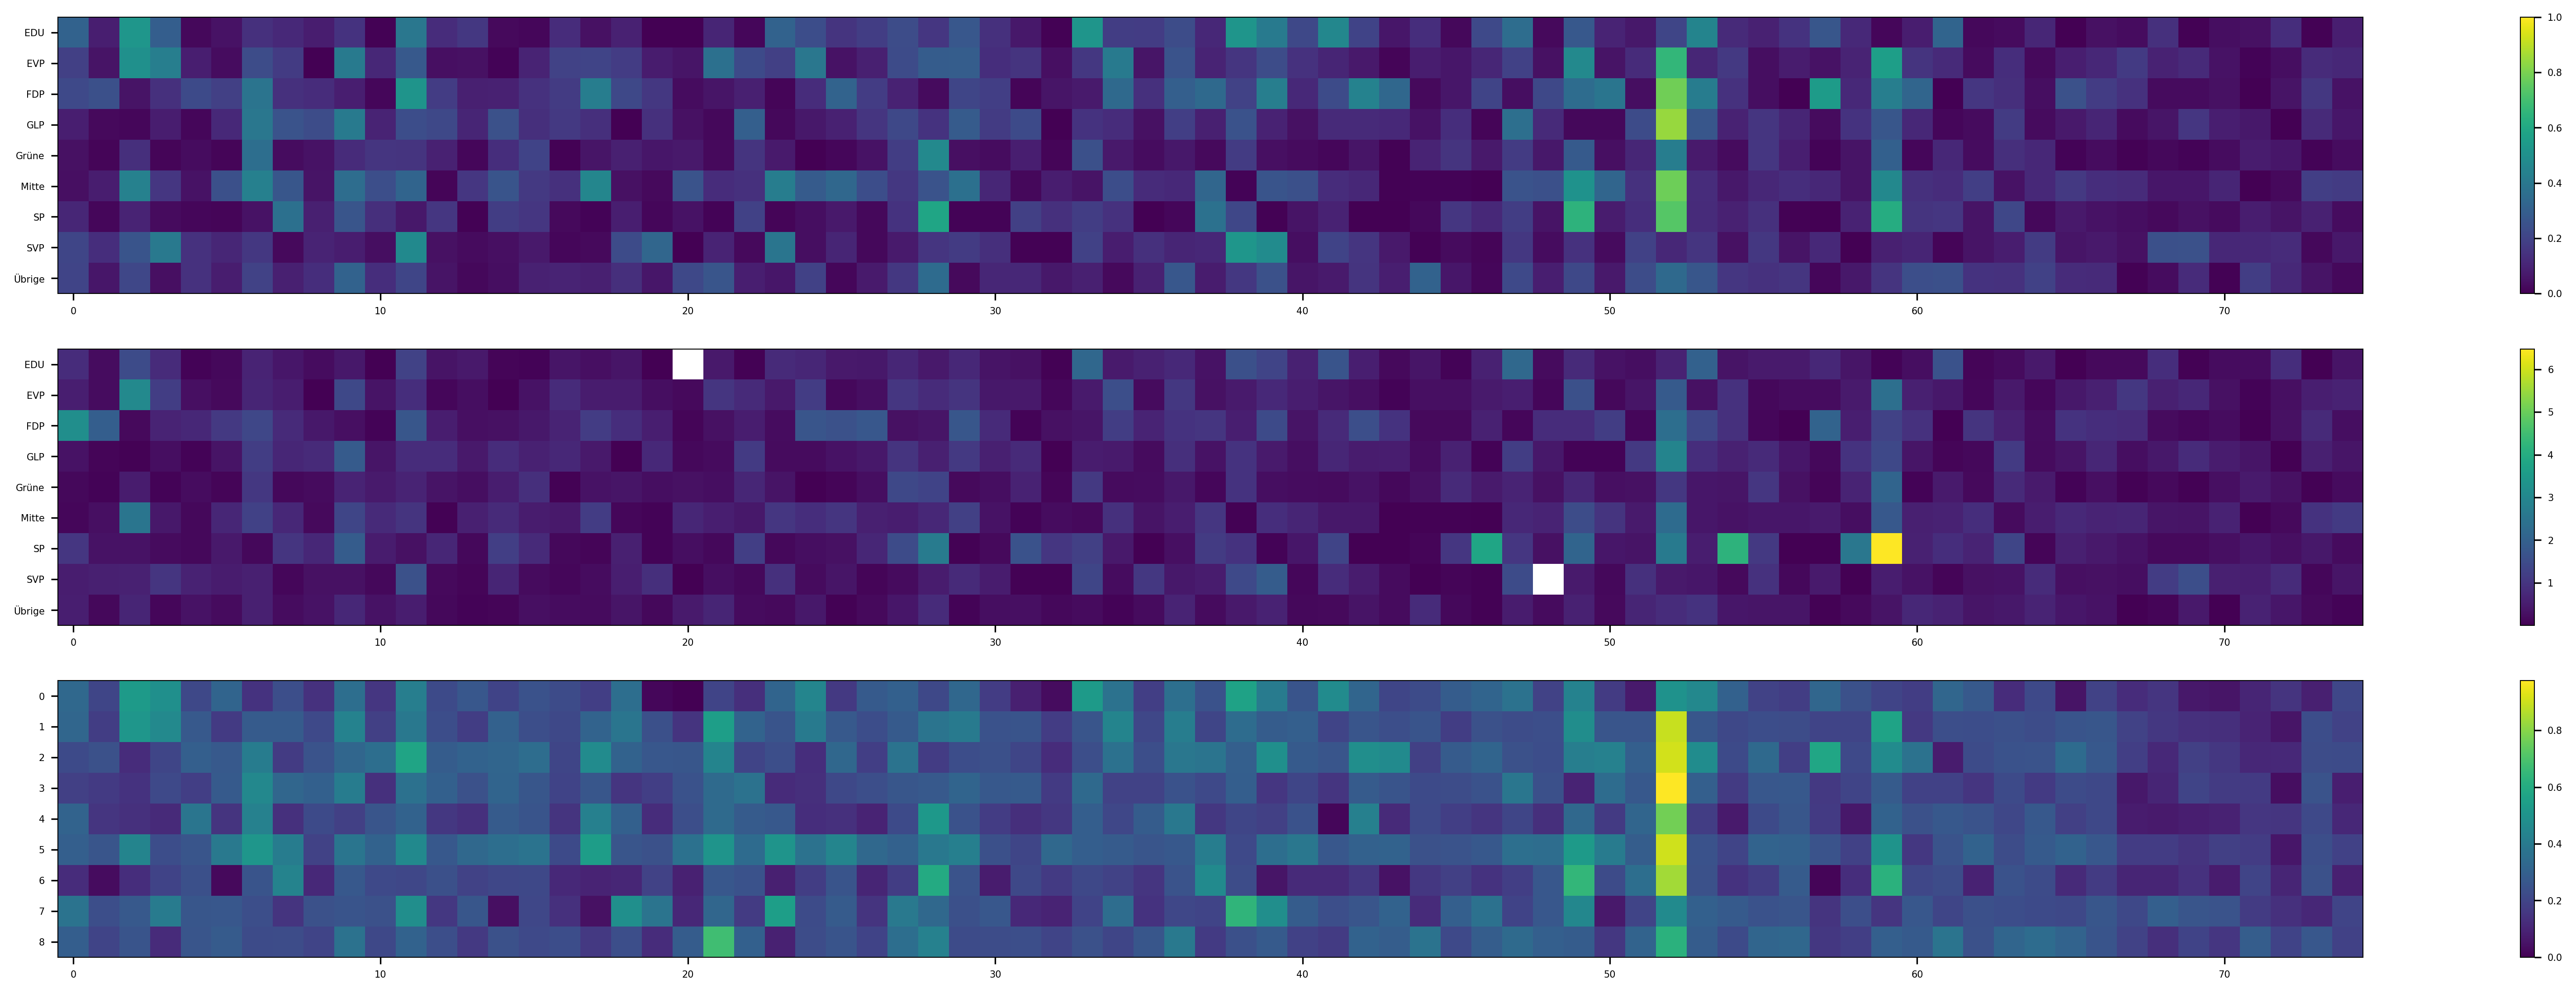

In [6]:
diff = (true_means - gpt_means).abs()

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(30,9))

image = ax1.imshow(diff.T, vmin=0, vmax=1)
ax1.set_yticks(ticks=range(len(diff.columns)), labels=diff.columns)
fig.colorbar(image, ax=ax1)

score = diff/true_stds

image = ax2.imshow(score.T)
ax2.set_yticks(ticks=range(len(score.columns)), labels=score.columns)
fig.colorbar(image, ax=ax2)

wass = np.sqrt( diff**2 + (np.sqrt(true_stds) - np.sqrt(gpt_stds))**2 )

image = ax3.imshow(wass.T)
ax2.set_yticks(ticks=range(len(wass.columns)), labels=wass.columns)
fig.colorbar(image, ax=ax3)

stats = pd.concat([diff.mean(), score.mean(), wass.mean()], axis=1)

stats.columns = columns=['diff', 'score', 'wass']
stats

#### GPT Prediction in ScatterBarPlot

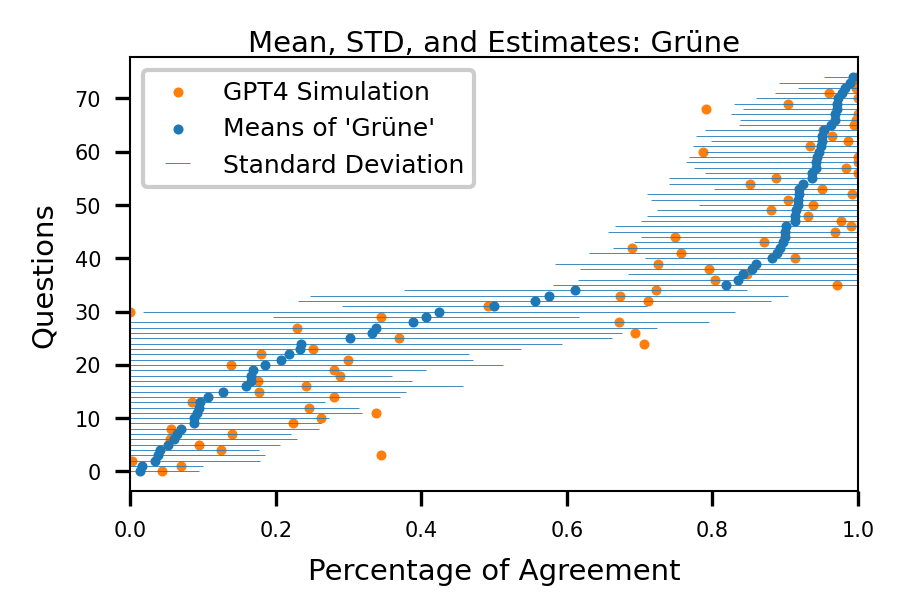

In [8]:
def scatter_error_plot(estimates, party):
    fig, ax = plt.subplots(figsize=(vis.columnwidth, 0.6*vis.columnwidth))
    # The x positions for the plot
    y_positions = range(len(true_means.loc[:,party]))
    
    means = true_means.loc[:,party].sort_values()
    stds = true_stds.loc[means.index,party]
    estimates = estimates.loc[means.index,party]

    # Plotting the estimates as scatter
    ax.scatter(estimates, y_positions, s=2, color='C1', label='GPT4 Simulation')
    
    # Plotting the means with std as horizontal error bars
    ax.scatter(means, y_positions, s=2, label=f"Means of '{party}'", color='C0')
    ax.errorbar(means, y_positions, xerr=stds, elinewidth=0.2, fmt='None', label='Standard Deviation', color='C0')

    # Adding labels and title
    ax.set(xlabel='Percentage of Agreement',
           ylabel='Questions',
           title=f'Mean, STD, and Estimates: {party}',
           xlim=(0,1)
    )
    # plt.yticks(x_positions)  # Set x-ticks to match the positions
    # Adding legend to distinguish between the two types of plots
    leg = ax.legend(facecolor='w')
    leg.get_frame().set_alpha(1)  
    return fig

_ = scatter_error_plot(gpt_means, 'Grüne')

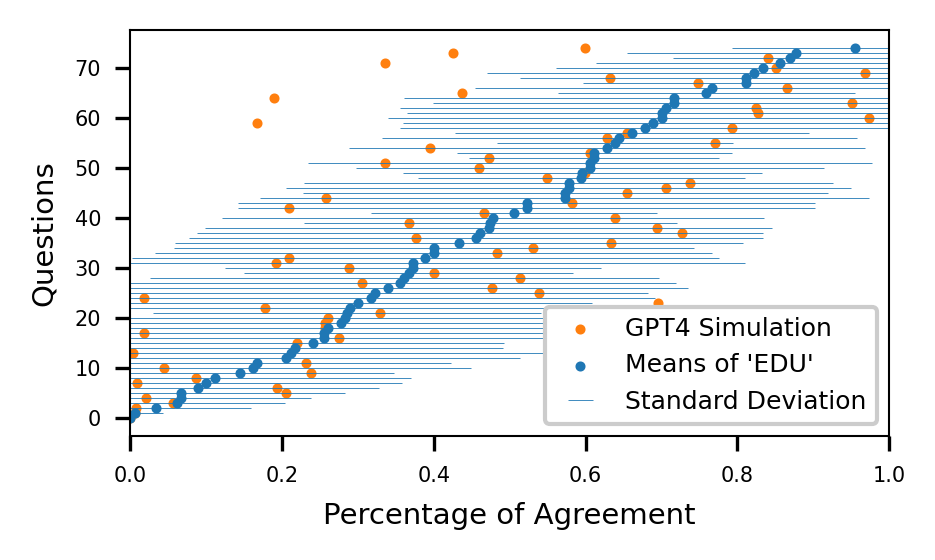

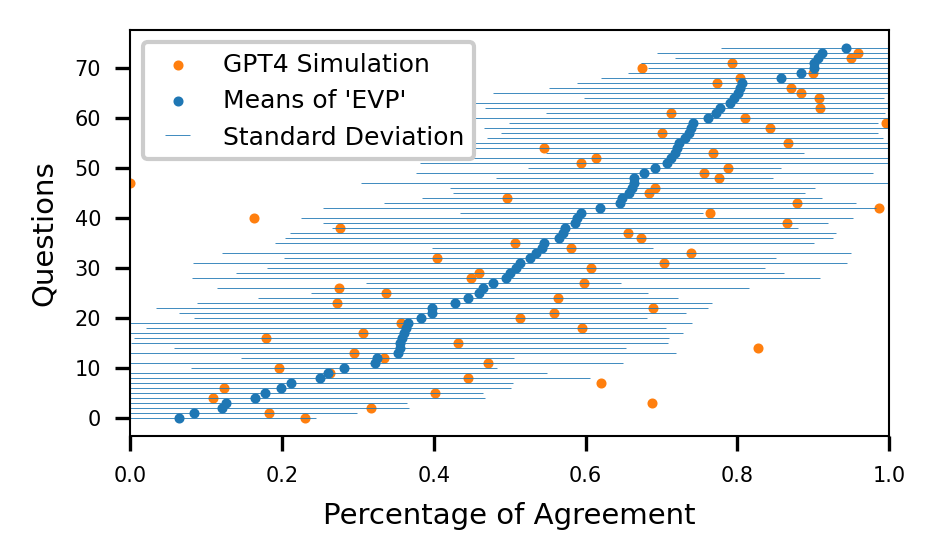

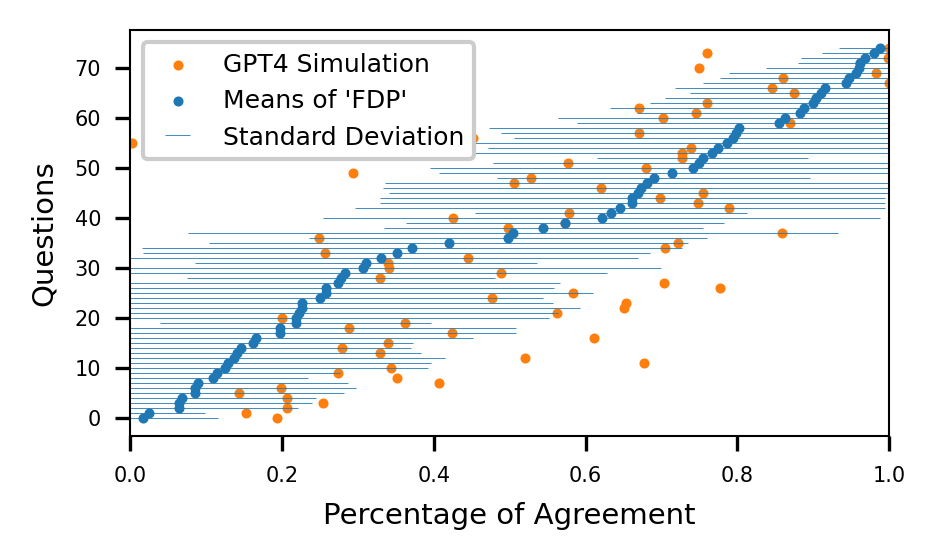

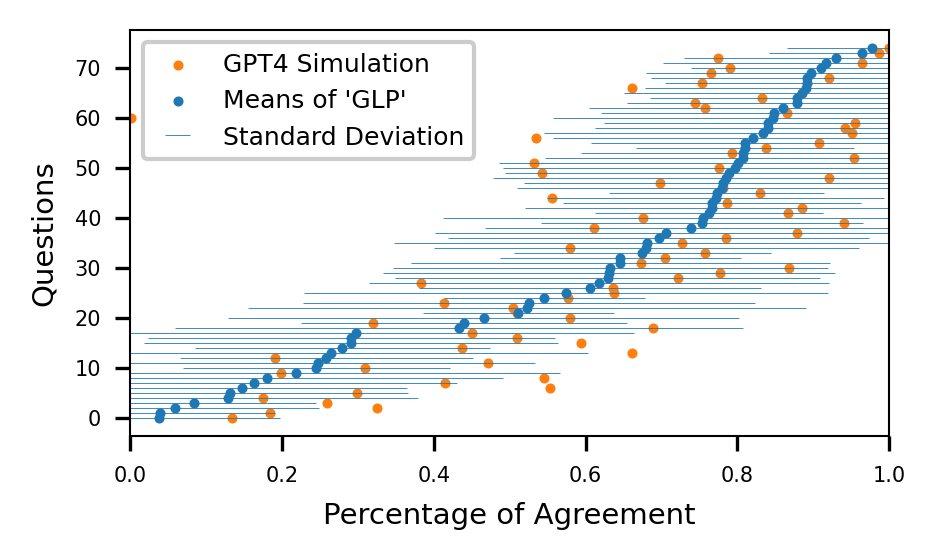

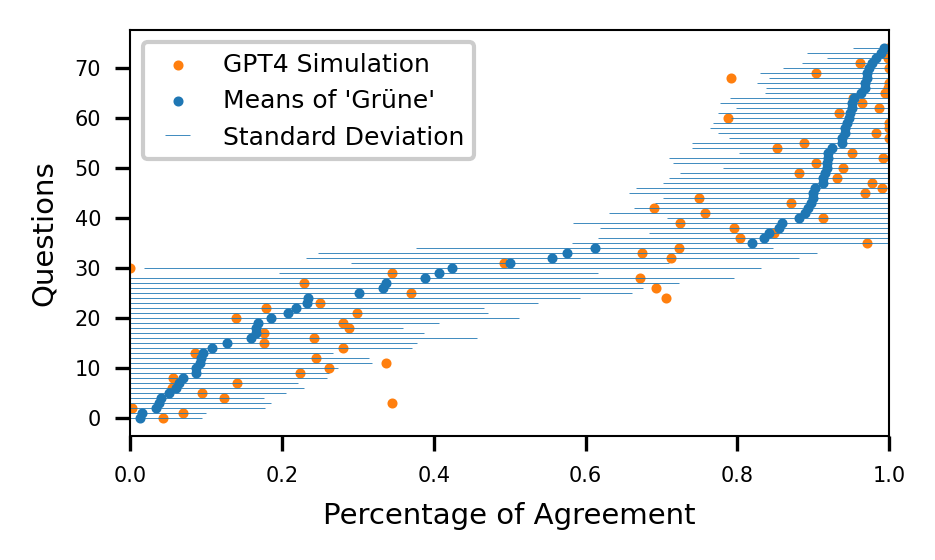

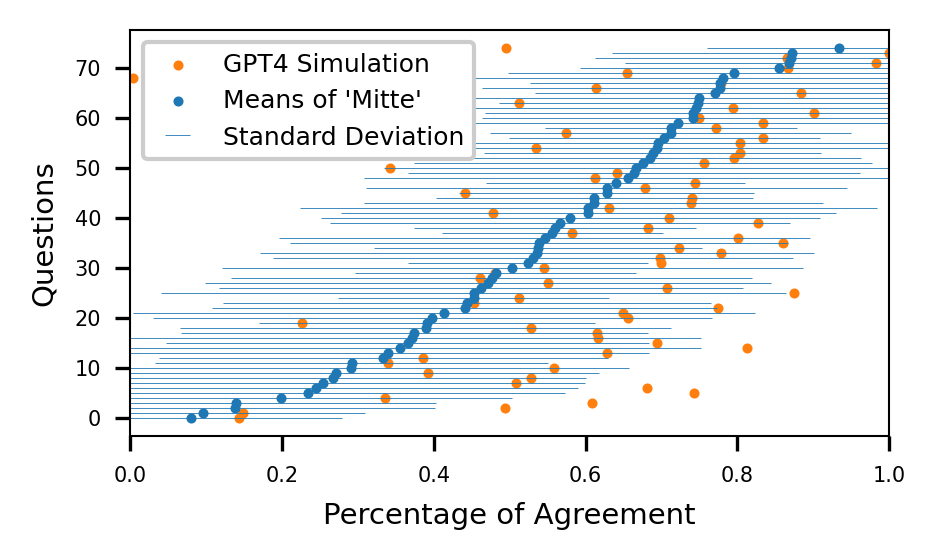

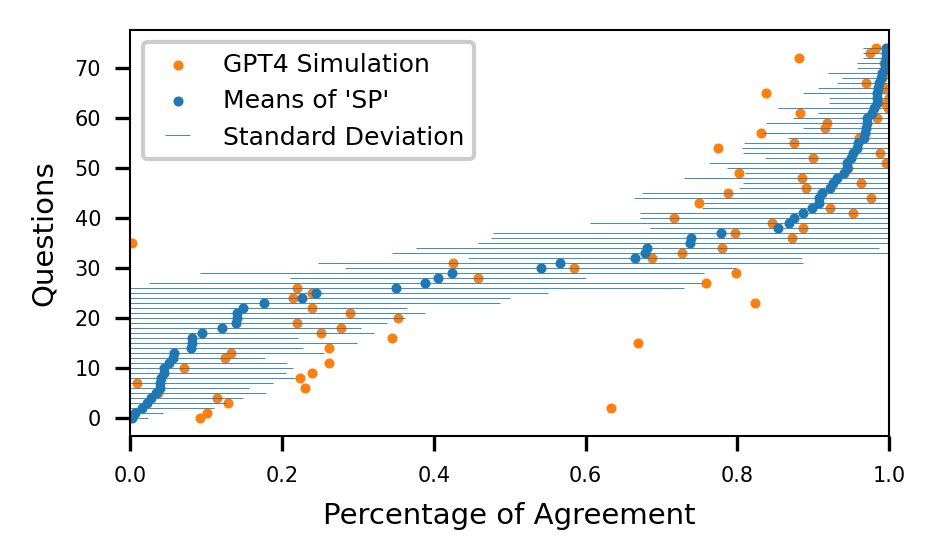

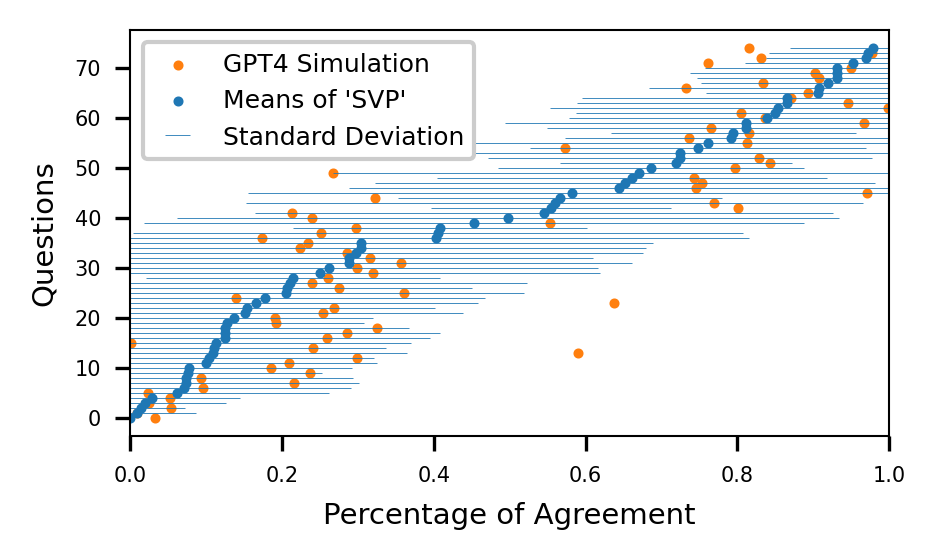

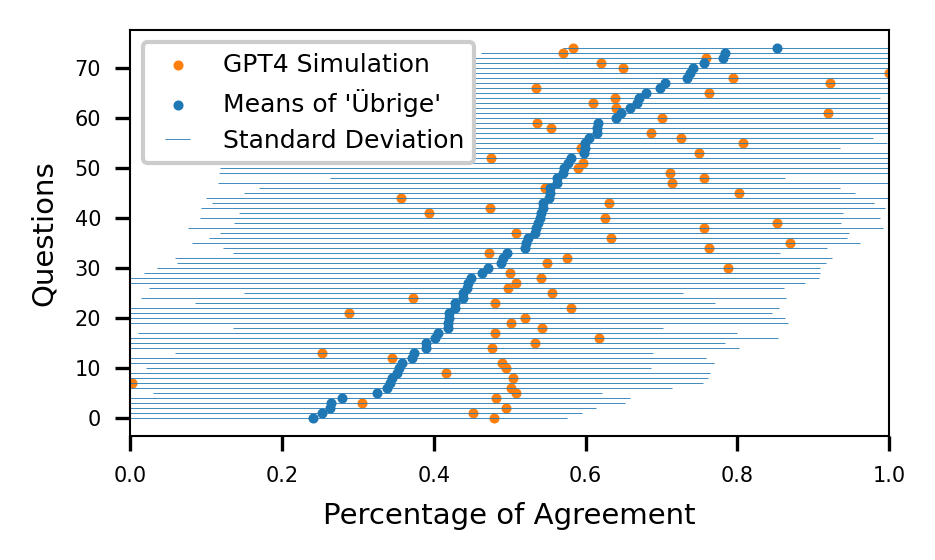

In [9]:
for party in true_means.columns:
    fig = scatter_error_plot(gpt_means,party)
    fig.axes[0].set_title('')
    fig.tight_layout()
    vis.savefig(fig, f'GPT_Estimates_{party}', save_figures)

In [29]:
pca = PCA(n_components=2)
Xv = pca.fit_transform(voters_reactions)
Xc = pca.transform(candidate_reactions)
Xg = pca.transform(gpt_data.fillna(.5))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


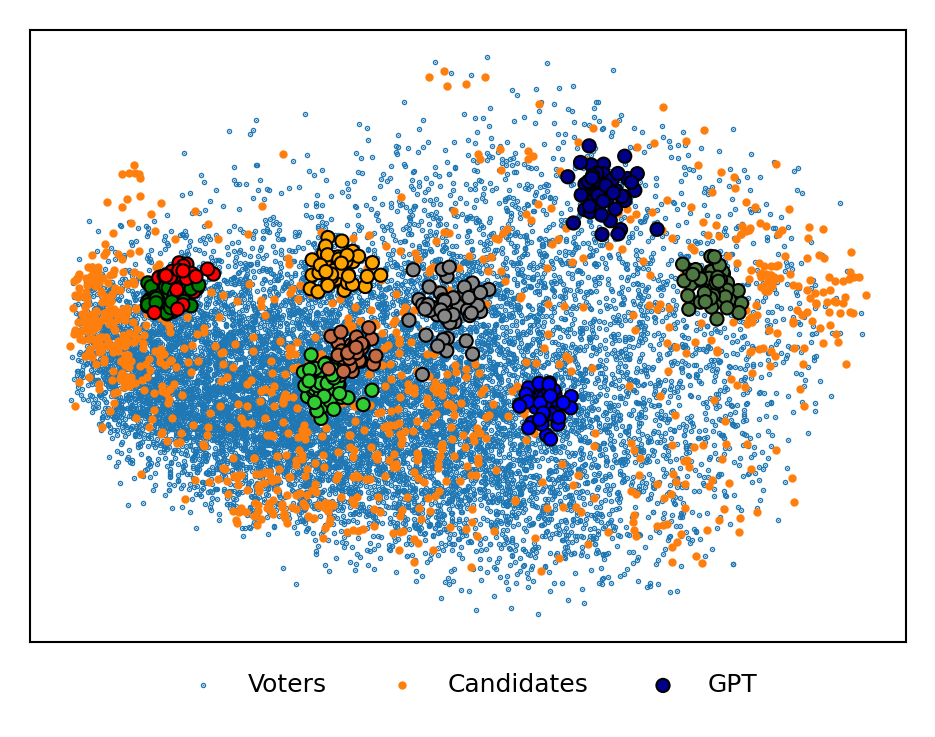

In [30]:
fig, ax = plt.subplots(figsize=(vis.columnwidth, 2*vis.columnwidth))
ax.scatter(Xv[:,0], Xv[:,1], s=.1, lw=None, label='Voters')
ax.scatter(Xc[:,0], Xc[:,1], s=1, label='Candidates')
colors = gpt_data.index.get_level_values(0).map(vis.party_colors)
ax.scatter(Xg[:,0], Xg[:,1], s=10, lw=0.5, c=colors, edgecolors='black',label='GPT')
ax.set_aspect('equal')
legend = ax.legend(loc='center', bbox_to_anchor=(.5, -.07), ncol=3, borderaxespad=0.,
                   frameon=False)
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
fig.tight_layout()
vis.savefig(fig, 'GPT_Voters_2023', save_figures)